## Introduction:
The goal of this project is to establish a robust intelligent system to aid in value investing efforts using stock market data. The system will help make investment decisions and based on intrinsic value of companies. It will not, however, trade on the basis of daily market volatility. This project is a part 1 of a series of 7 companies. At the end of the project we will be able to:


1.   Predict stock price valuations on a daily, weekly and monthly basis
2.   Recommend to buy, sell or hold based on certain decision parameters
3.   Maximize capital returns, minimise loses, and minise hold periods



## Loading Libraries And Data For Medinet Nasr Housing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df = pd.read_excel('/content/2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name='Egypt - Medinet Nasr Housing (M')

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,3.75,3.74,3.82,3.71,1.57M,0.0054
1,2021-03-30 00:00:00,3.73,3.71,3.76,3.67,3.43M,0.0081
2,2021-03-29 00:00:00,3.7,3.69,3.73,3.68,1.25M,-0.0027
3,2021-03-28 00:00:00,3.71,3.76,3.76,3.68,2.34M,0.0000
4,2021-03-25 00:00:00,3.71,3.62,3.78,3.59,2.50M,0.0137


## Data Wrangling

In [ ]:
df.shape

(306, 7)

In [ ]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
301,2020-01-08 00:00:00,4.41,4.19,4.59,4.15,3.52M,0.0304
302,2020-01-06 00:00:00,4.28,4.16,4.44,4.12,2.52M,-0.0295
303,2020-01-05 00:00:00,4.41,4.7,4.7,4.33,3.76M,-0.0832
304,2020-01-02 00:00:00,4.81,4.81,4.87,4.78,241.60K,-0.0021
305,Highest: 4.92,Lowest: 2.40,Difference: 2.52,Average: 3.55,Change %: -22.20,NaN,NaN


In [ ]:
df = df[:-1]

In [ ]:
df.isna().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [ ]:
df.dtypes

Date         object
Price        object
Open         object
High         object
Low          object
Vol.         object
Change %    float64
dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df['Vol.'].str[-1] == 'K'

Date
2021-03-31    False
2021-03-30    False
2021-03-29    False
2021-03-28    False
2021-03-25    False
              ...  
2020-01-09    False
2020-01-08    False
2020-01-06    False
2020-01-05    False
2020-01-02     True
Name: Vol., Length: 305, dtype: bool

In [ ]:
def convert_volume(x):
    if x.endswith('K'):
        return float(x[:-1]) * 1000
    elif x.endswith('M'):
        return float(x[:-1]) * 1000000
    else:
        return float(x)

In [ ]:
df['Vol.'] = df['Vol.'].apply(convert_volume)

In [ ]:
for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = df[i].astype(float)

In [ ]:
df['Price'].describe()

count    305.000000
mean       3.554033
std        0.621462
min        2.470000
25%        3.030000
50%        3.700000
75%        3.920000
max        4.890000
Name: Price, dtype: float64

## Exploratory Data Analysis

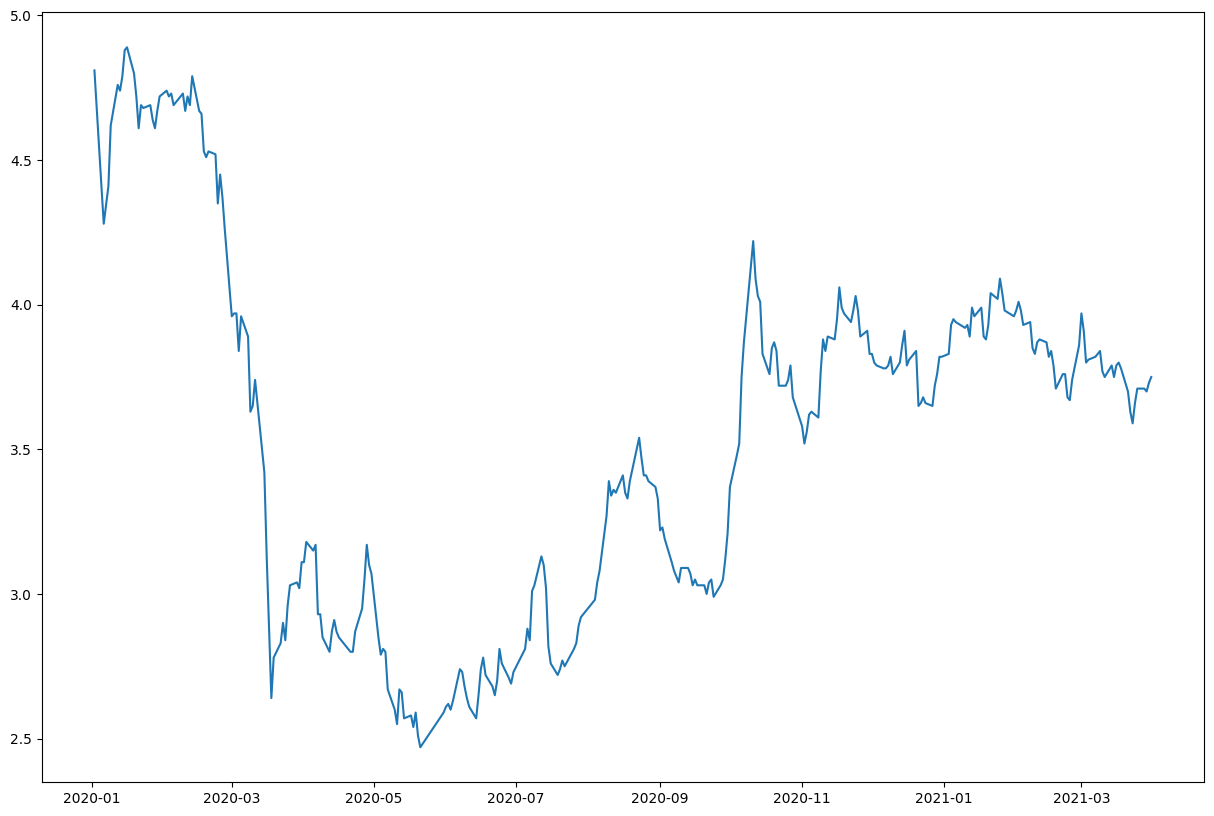

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['Price'])
plt.show()

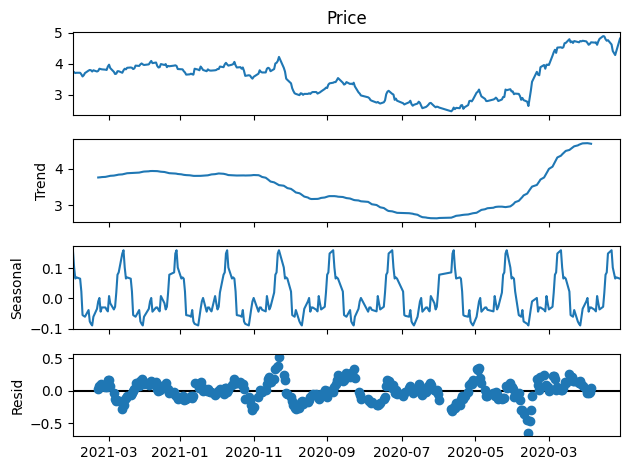

In [ ]:
decomp = seasonal_decompose(df['Price'], model='additive', period=30)
decomp.plot()
plt.show()

## Modeling And Preprocessing

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(df['Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.768273
p-value: 0.828264
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [ ]:
def stationarity_check(value):
  if value < 0.05:
    print(f'Data is Stationary')
  else:
    print(f'Data is Non-Stationary')
stationarity_check(result[1])

Data is Non-Stationary


In [ ]:
df['price_diff'] = df['Price'].diff()
df.dropna(inplace=True)

In [ ]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df.dropna(inplace=True)

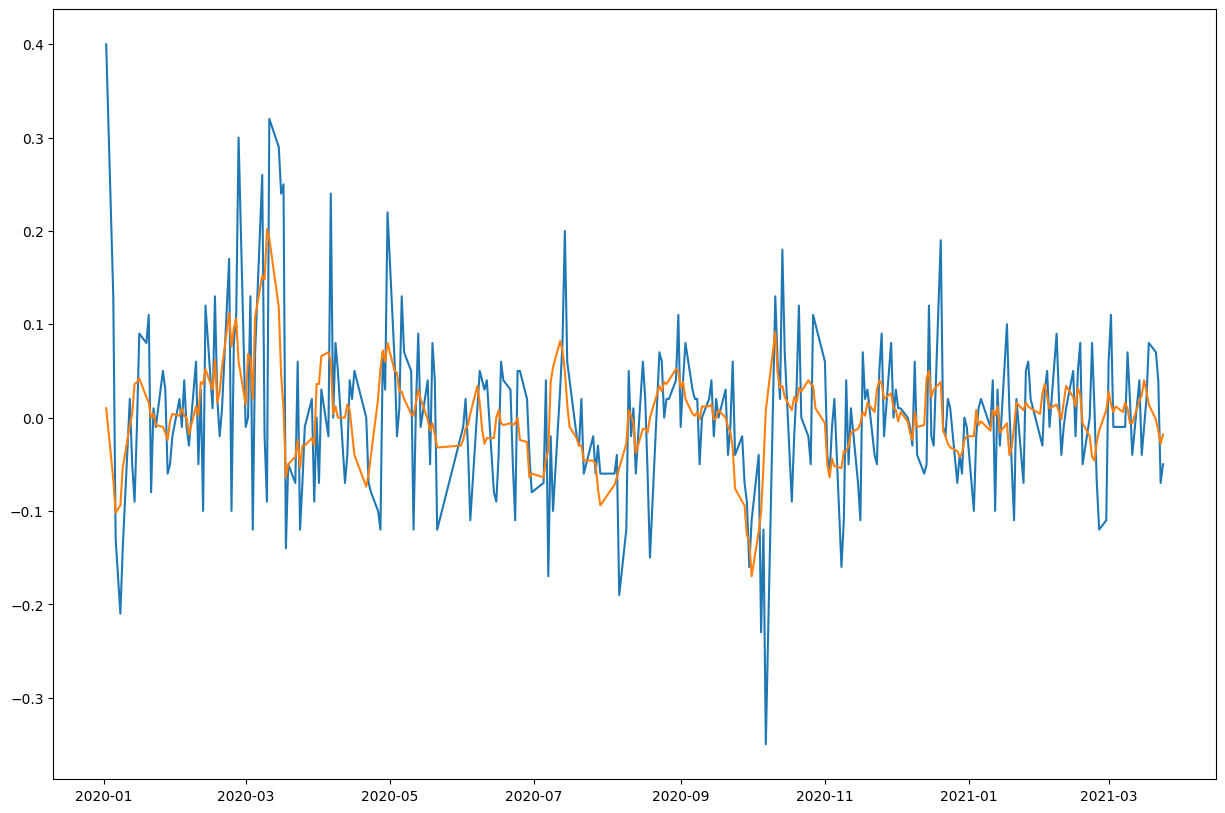

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['price_diff'])
plt.plot(df['rolling_mean_diff'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
df_train = df['2020-01-01':'2021-01-01']
df_test = df['2021-01-01':]


## Creating The ARIMA Model



In [ ]:
def evaluate_arima_model(data, arima_order):
  train, test = df_train['rolling_mean_diff'].values, df_test['rolling_mean_diff'].values
  past = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(past, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    past.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

## Finding The Right Order For The ARIMA Model

In [ ]:
def evaluate_models(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p, q, d)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order, mse))
        except:
          continue
  return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [ ]:
p = 2
d = 1
q = 2
model = ARIMA(df_train['rolling_mean_diff'], order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(df_test))

# Plotting The Fitted Model

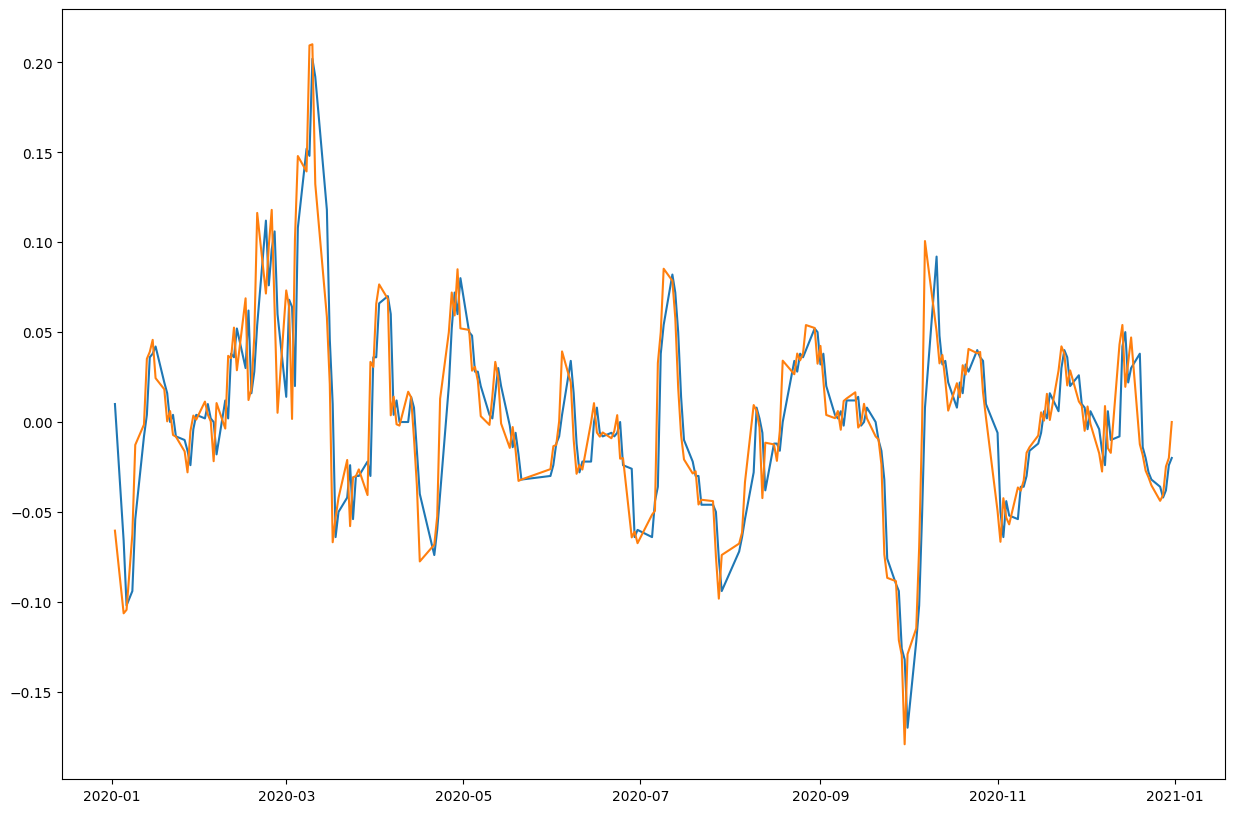

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df_train['rolling_mean_diff'])
plt.plot(model_fit.predict())
plt.show()

In [ ]:
future_cast = model_fit.forecast(len(df_test))
future_cast.index = df_test.index
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

# Plotting The Forecast

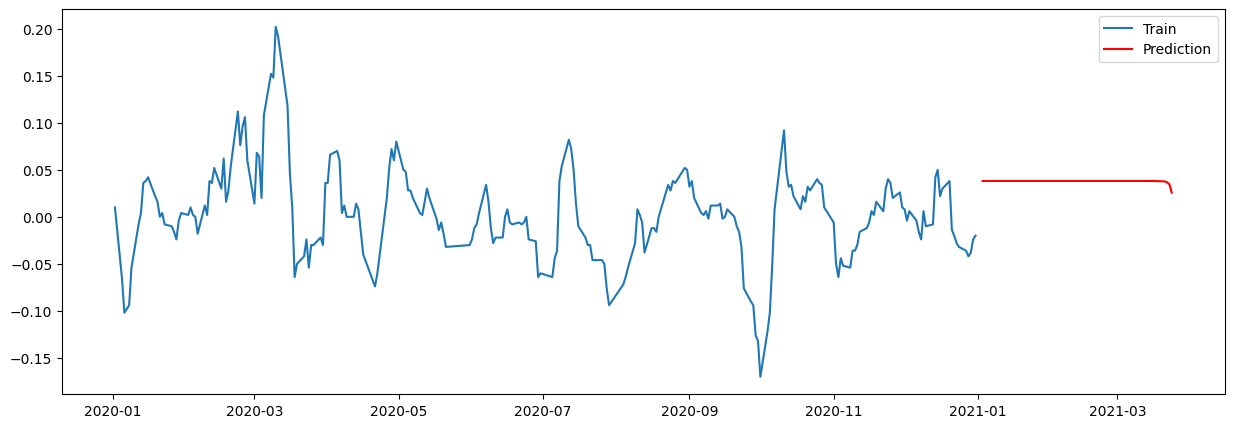

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean_diff'], label='Train')
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')
plt.legend()
plt.show()

## Back Testing The Model

In [ ]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse , mae, predictions

In [ ]:
mse, mae, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (2, 1, 2), len(df_train))

In [ ]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-01-03,-0.017327
2021-01-04,-0.019748
2021-01-05,0.016928
2021-01-06,-0.010129
2021-01-10,-0.004718


In [ ]:
f_std = forecast['rolling_mean_diff'].std()

## Plotting The Forecast With Bollinger Bands

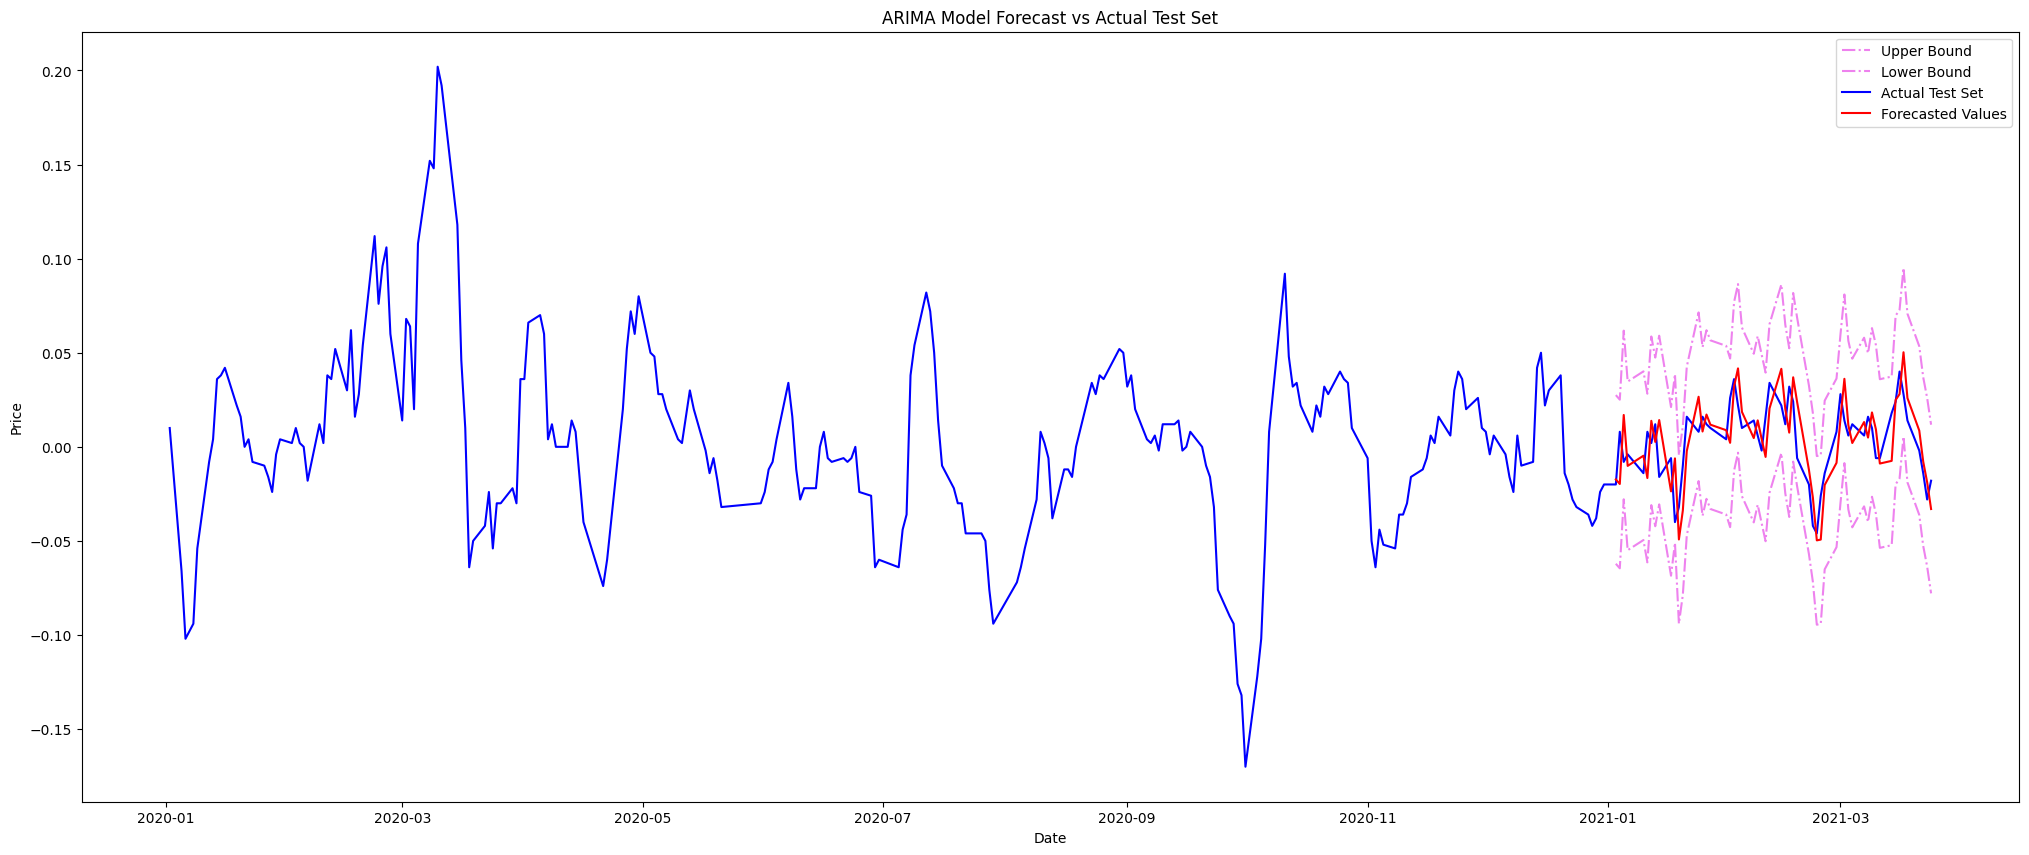

In [ ]:
plt.figure(figsize=(25,10))
plt.plot(forecast['rolling_mean_diff'] + 1.96*f_std, label='Upper Bound', color='violet', linestyle='-.')
plt.plot(forecast['rolling_mean_diff'] - 1.96*f_std, label='Lower Bound', color='violet', linestyle='-.')
plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

plt.plot(forecast, label='Forecasted Values', color='red')

plt.title('ARIMA Model Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Decisions: Buy, Sell, Or Hold

In [ ]:
def buy_sell_hold(forecast, look_ahead, data, threshold=1.96):
  standard_dev = data['rolling_mean_diff'].std()
  decisions = []
  open_prices = []
  dates = []
  buy_sell_flag = 'buy'
  for i in range(len(forecast) - look_ahead):
    if standard_dev is None:
      return "Please provide standard deviation"
    else:
      open_prices.append(data['Open'].iloc[i])
      dates.append(forecast.index[i])
      if (forecast.iloc[i + look_ahead] > forecast.iloc[i] + threshold * standard_dev) & (buy_sell_flag != 'buy'):
        decisions.append('buy')
        buy_sell_flag = 'buy'
      elif (forecast.iloc[i + look_ahead] < forecast.iloc[i] - threshold * standard_dev) & (buy_sell_flag != 'sell'):
        decisions.append('sell')
        buy_sell_flag = 'sell'
      else:
        decisions.append('hold')
  df = pd.DataFrame({'Decision': decisions, 'Open': open_prices}, index=dates)
  return df

In [ ]:
decision_df = buy_sell_hold(forecast['rolling_mean_diff'], look_ahead=7, data=df, threshold=0.1)

In [ ]:
decision_df.head(30)

,Decision,Open
2021-01-03,hold,3.69
2021-01-04,hold,3.57
2021-01-05,sell,3.70
2021-01-06,hold,3.79
2021-01-10,hold,3.77
2021-01-11,hold,3.85
2021-01-12,hold,3.78
2021-01-13,buy,3.78
2021-01-14,sell,3.76
2021-01-17,buy,3.80


## Assessing Profit Based On Decision Parameters

In [ ]:
def decision_score(lst):
  score = 0
  for i in range(len(lst)):
    if lst[i] == 'buy':
      score += 1
    elif lst[i] == 'sell':
      score -= 1
    else:
      score += 0
  return score

In [ ]:
decision_score(decision_df['Decision'])

-1